![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Finance/07.0.Understand_Entities_in_Context.ipynb)

# Understanding Financial Entities In Context
Assertion Status, or *Understanding Financial Entities in Context*, is an NLP atsk in carge of analyzing NER entities, extracted with:
- NER models;
- ContextualParser;

and their surroundings (usually a sentence, but it could take bigger spans too) to *assert* different conditions / status on the entities, as:
- If an entity is negated in the context;
- If the context talks about past, present, or future;
- If the entity is said to be hypothetical / possible, or certaing;
- etc.

The exposed above are just some examples, since the applications of Assertion DL models can be expanded to whatever to many other scenarios where you need to:
- Disambiguate entities from the context.
- Subclassify or specify an entity depending on context:

Examples:
- Is an ORG mentioned to be a COMPETITOR or part of the SUPPLY_CHAIN (or none of them)?
- Is an ACQUIRED_COMPANY mentioned to be acquired TOTALLY or PARTIALLY acquired in the context?
- etc



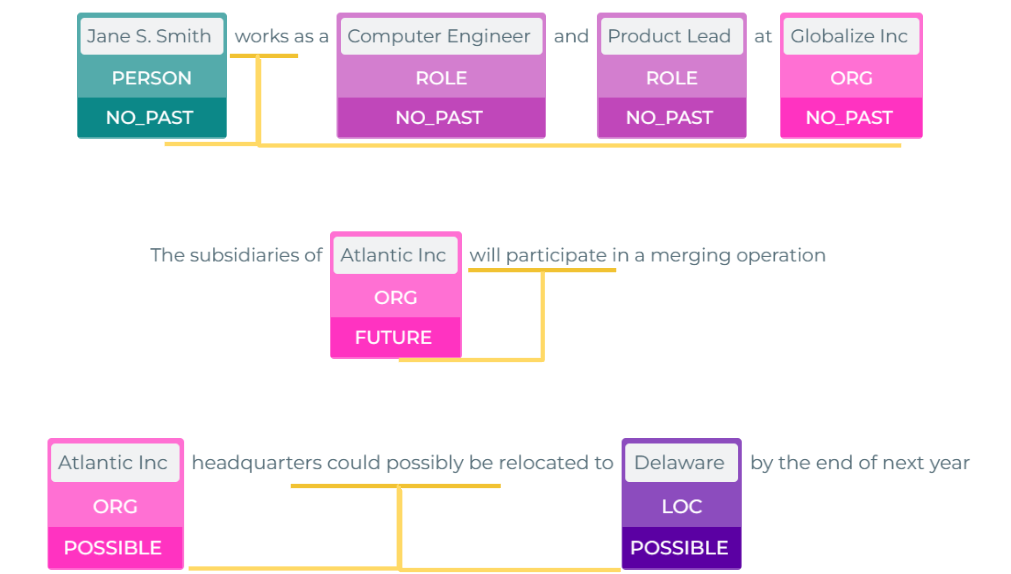

Let's see which pretrained models we have and how to train custom ones!

# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using [my.johnsnowlabs.com](https://my.johnsnowlabs.com/) SSO

In [ ]:
from johnsnowlabs import nlp, finance

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to [my.johnsnowlabs.com](https://my.johnsnowlabs.com/)
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

## Start Spark Session

In [ ]:
from johnsnowlabs import nlp, finance
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

👌 Detected license file /content/spark_nlp_for_healthcare_spark_ocr_7162 (4).json
👌 Launched cpu optimized session with with: 🚀Spark-NLP==4.2.4, 💊Spark-Healthcare==4.2.4, running on ⚡ PySpark==3.1.2


In [ ]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

## Understanding time from context

### Past Experiences of a Role (C-level management)
Let's start with a small example: analyzing whether a ROLE of a person in a company is mentioned to be a `past` or `present`.

For that, we need:
- An NER model. We will use `finner_bert_roles` which uses `bert_embeddings_sec_bert_base` embeddings to extract `ROLE` entities;
- An Assertion Model which detects time. We will use `finassertiondl_past_roles` which is a very specific one, to detect time in `ROLE` entities.

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["document"])\
    .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("embeddings")

tokenClassifier = finance.BertForTokenClassification.pretrained("finner_bert_roles","en","finance/models")\
    .setInputCols("token", "document")\
    .setOutputCol("ner")\
    .setCaseSensitive(True)

ner_converter = finance.NerConverterInternal() \
    .setInputCols(["document", "token", "ner"]) \
    .setOutputCol("ner_chunk")\
    .setWhiteList(["ROLE"])

assertion = finance.AssertionDLModel.pretrained("finassertiondl_past_roles", "en", "finance/models")\
    .setInputCols(["document", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
    
nlpPipeline = nlp.Pipeline(stages=[
    document_assembler, 
    tokenizer,
    embeddings,
    tokenClassifier,
    ner_converter,
    assertion
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

light_model = nlp.LightPipeline(model)

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_bert_roles download started this may take some time.
[OK!]
finassertiondl_past_roles download started this may take some time.
[OK!]


### Example sentences extracted from 10K filings

In [ ]:
sample_texts = ["""From January 2009 to November 2017, Mr. Tan worked as the Managing Director of Cadence""",
                """Jane S. Smith works as a Computer Engineer and Product Lead at Globalize Cloud Services""",
                """Mrs. Johansson has been apointed CEO and President of Mileways""",
                """Tom Martin worked as Cadence's CTO until 2010""",
                """Mrs. Charles was before Managing Director at a big consultancy company""",
                """We are happy to announce that Mary Leigh joins Elephant as Web Designer and UX/UI Developer"""]

### We extract with LightPipelines

In [ ]:
import pandas as pd

chunks=[]
entities=[]
status=[]

for i in range(len(sample_texts)):
  light_result = light_model.fullAnnotate(sample_texts[i])[0]

  for n,m in zip(light_result['ner_chunk'],light_result['assertion']):
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

In [ ]:
df

,chunks,entities,assertion
0,Director,ROLE,PAST
1,Computer Engineer,ROLE,NO_PAST
2,Product Lead,ROLE,NO_PAST
3,CEO,ROLE,NO_PAST
4,President,ROLE,NO_PAST
5,Cadence's CTO,ROLE,PAST
6,Managing Director,ROLE,PAST
7,Web Designer,ROLE,NO_PAST
8,UX/UI Developer,ROLE,NO_PAST


### Visualization of Assertion Status

In [ ]:
for i in range(len(sample_texts)):
    
    light_result = light_model.fullAnnotate(sample_texts[i])[0]
    
    vis = nlp.viz.AssertionVisualizer()

    vis.display(light_result, 'ner_chunk', 'assertion')

## Bigger example: Asserting time in a 10-K filing
Now let's go bigger. We will use one 10K filing, extract several pages and apply assertion status to detect time for:
- `PER` (people)
- `ORG` (organizations)
- `ROLE` (roles of those people in that or past organizations)

For that, we need:
- An NER model. We will use `finner_org_per_role_date` which uses `bert_embeddings_sec_bert_base` embeddings to extract `PERSON`, `ORG` and `ROLE` entities;
- An Assertion Model which detects time. We will use `finassertion_time` which is a generic time assertion model, to detect time on the previously mentioned entities. 

**Please keep in mind that you can use this model also in other entities, but the performance may degrade since it was not trained on other kind of entities.**

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/cdns-20220101.html.txt

--2023-01-23 20:55:24--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/cdns-20220101.html.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347392 (339K) [text/plain]
Saving to: ‘cdns-20220101.html.txt’

cdns-20220101.html. 100%[===================>] 339.25K  --.-KB/s    in 0.02s   

2023-01-23 20:55:24 (17.9 MB/s) - ‘cdns-20220101.html.txt’ saved [347392/347392]



In [ ]:
import requests
URL = "https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/cdns-20220101.html.txt"
response = requests.get(URL)

cadence_sec10k = response.content.decode('utf-8')

In [ ]:
document_assembler = nlp.DocumentAssembler() \
    .setInputCol("text") \
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("pages")\
    .setCustomBounds(["Table of Contents"])\
    .setUseCustomBoundsOnly(True)\
    .setExplodeSentences(True)

nlp_pipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentence_detector])

In [ ]:
#fit: trains, configures and prepares the pipeline for inference. 

sdf = spark.createDataFrame([[ cadence_sec10k ]]).toDF("text")

fit = nlp_pipeline.fit(sdf)

In [ ]:
%%time

#transforms: executes inference on a fit pipeline
res = fit.transform(sdf)

res.show()

+--------------------+--------------------+--------------------+
|                text|            document|               pages|
+--------------------+--------------------+--------------------+
|Table of Contents...|[{document, 0, 34...|[{document, 18, 4...|
|Table of Contents...|[{document, 0, 34...|[{document, 4087,...|
|Table of Contents...|[{document, 0, 34...|[{document, 4215,...|
|Table of Contents...|[{document, 0, 34...|[{document, 5504,...|
|Table of Contents...|[{document, 0, 34...|[{document, 11617...|
|Table of Contents...|[{document, 0, 34...|[{document, 13985...|
|Table of Contents...|[{document, 0, 34...|[{document, 20001...|
|Table of Contents...|[{document, 0, 34...|[{document, 26059...|
|Table of Contents...|[{document, 0, 34...|[{document, 31638...|
|Table of Contents...|[{document, 0, 34...|[{document, 36733...|
|Table of Contents...|[{document, 0, 34...|[{document, 42440...|
|Table of Contents...|[{document, 0, 34...|[{document, 47053...|
|Table of Contents...|[{d

In [ ]:
%%time

import json

lp = nlp.LightPipeline(fit)

json_res = lp.annotate(cadence_sec10k)

print(json.dumps(json_res, indent=4))

{
    "document": [
        "Table of Contents\nUNITED STATES SECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n_____________________________________ \nFORM 10-K \n_____________________________________  \n(Mark One)\n\u2612\nANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the fiscal year ended January 1, 2022 \nOR\n\u2610\nTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\nFor the transition period from _________ to_________.\n\nCommission file number 000-15867 \n_____________________________________\n \nCADENCE DESIGN SYSTEMS, INC. \n(Exact name of registrant as specified in its charter)\n____________________________________ \nDelaware\n \n00-0000000\n(State or Other Jurisdiction ofIncorporation or Organization)\n \n(I.R.S. EmployerIdentification No.)\n2655 Seely Avenue, Building 5,\nSan Jose,\nCalifornia\n \n95134\n(Address of Principal Executive Offices)\n \n(Zip Code)\n(408)\n-943-1234 \n(Reg

In [ ]:
pages = [json_res['pages'][i] for i in range(13)]

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentencizer = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

ner = finance.NerModel.pretrained("finner_org_per_role_date", "en", "finance/models")\
    .setInputCols("sentence", "token", "embeddings")\
    .setOutputCol("ner")

chunk_converter = nlp.NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

assertion = finance.AssertionDLModel.pretrained("finassertion_time", "en", "finance/models")\
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
    
nlpPipeline = nlp.Pipeline(stages=[
    document_assembler,
    sentencizer,
    tokenizer,
    embeddings,
    ner,
    chunk_converter,
    assertion
    ])

empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)

lp = nlp.LightPipeline(model)

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_org_per_role_date download started this may take some time.
[OK!]
finassertion_time download started this may take some time.
[OK!]


Let's start identifying time using `finassertion_time`. As in previous notebooks, we will be using a SEC 10K filing.

In [ ]:
from johnsnowlabs import viz

texts = [pages[12]]

res = lp.fullAnnotate(texts)

vis = viz.AssertionVisualizer()

for r in res:
  vis.display(r, 'ner_chunk', 'assertion')

## Identify COMPETITORS in a Text with Assertion Status

This model uses Assertion Status to identify if a **PRODUCT** or an **ORG** is mentioned to be a `COMPETITOR`. By default, if nothing is mentioned, it returns `NO_COMPETITOR`.

Again, this is a model uses the context around `PRODUCT` or `ORGANIZATION` to further subclassify them.

For that, we need:
- An NER model. We will use `finner_org_prod_alias` which uses `bert_embeddings_sec_bert_base` embeddings to extract `ORPG`, `PRODUCT` and `ALIAS` entities;
- An Assertion Model which detects time. We will use `finassertion_competitors` which retrieves if a company or product is a `COMPETITOR` or `NO_COMPETITOR`

**Please keep in mind that you can use this model also in other entities, but the performance may be affected**


In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Sentence Detector annotator, processes various sentences per line
sentence_detector =  nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

# Tokenizer splits words in a relevant format for NLP
tokenizer =  nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings =  nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

ner_model = finance.NerModel.pretrained("finner_orgs_prods_alias","en","finance/models")\
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner")\

ner_converter = finance.NerConverterInternal() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")\

assertion = finance.AssertionDLModel.pretrained("finassertion_competitors", "en", "finance/models")\
    .setInputCols(["sentence", "ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")
    
pipeline = nlp.Pipeline(stages=[
    document_assembler, 
    sentence_detector,
    tokenizer,
    embeddings,
    ner_model,
    ner_converter,
    assertion
    ])

empty_df = spark.createDataFrame([[""]]).toDF("text")

model = pipeline.fit(empty_df)

light_model = nlp.LightPipeline(model)

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
finner_orgs_prods_alias download started this may take some time.
[OK!]
finassertion_competitors download started this may take some time.
[OK!]


### Some examples 

In [ ]:
sample_text = """Our competitors include the following by general category: legacy antivirus product providers, such as McAfee LLC and Broadcom Inc."""

In [ ]:
data = spark.createDataFrame([[sample_text]]).toDF("text")

In [ ]:
result = model.transform(data)

In [ ]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result, result.ner_chunk.metadata, result.assertion.result)).alias("cols"))\
      .select(F.expr("cols['1']['sentence']").alias("sent_id"),
              F.expr("cols['0']").alias("chunk"),
              F.expr("cols['1']['entity']").alias("ner_label"),
              F.expr("cols['2']").alias("assertion")).show(truncate=False)

+-------+------------+---------+----------+
|sent_id|chunk       |ner_label|assertion |
+-------+------------+---------+----------+
|0      |McAfee LLC  |ORG      |COMPETITOR|
|0      |Broadcom Inc|ORG      |COMPETITOR|
+-------+------------+---------+----------+



### Quick inference with LightPipeline

In [ ]:
import pandas as pd

light_result = light_model.fullAnnotate(sample_text)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):
    
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)
        
df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

df

,chunks,entities,assertion
0,McAfee LLC,ORG,COMPETITOR
1,Broadcom Inc,ORG,COMPETITOR


### Visualization of Assertion Status (`COMPETITOR` example)

In [ ]:
# from sparknlp_display import AssertionVisualizer

vis = nlp.viz.AssertionVisualizer()

vis.display(light_result, 'ner_chunk', 'assertion')

## Writing a Generic Assertion + NER Function
You can generalize and retrieve components or full pipelines using functions.

This is an example of how you can achieve that.

In [ ]:
def get_base_pipeline(embeddings):

    documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

    sentenceDetector = nlp.SentenceDetector()\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

    tokenizer = nlp.Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

    embeddings = nlp.BertEmbeddings.pretrained(embeddings, "en") \
        .setInputCols(["sentence", "token"]) \
        .setOutputCol("embeddings")

    base_pipeline = nlp.Pipeline(stages=[
                        document_assembler,
                        sentence_detector,
                        tokenizer,
                        embeddings])

    return base_pipeline


def get_assertion (embeddings, ner_model, assertion_model):

    ner = finance.NerModel.pretrained(ner_model, "en", "finance/models")\
        .setInputCols(["sentence", "token", "embeddings"]) \
        .setOutputCol("ner")

    ner_converter = nlp.NerConverter() \
        .setInputCols(["sentence", "token", "ner"]) \
        .setOutputCol("ner_chunk")
    
    assertion = finance.AssertionDLModel.pretrained(assertion_model, "en", "finance/models")\
        .setInputCols(["sentence", "ner_chunk", "embeddings"])\
        .setOutputCol("assertion")
      
    base_model = get_base_pipeline(embeddings)

    nlpPipeline = nlp.Pipeline(stages=[
        base_model,
        ner,
        ner_converter,
        assertion])

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    model = nlpPipeline.fit(empty_data)
    
    light_model = nlp.LightPipeline(model)
    
    return light_model
    

### Quick inference with LightPipeline

In [ ]:
sample_text = """EDH combines our Cloudera Data Warehouse, Cloudera Operational DB, and Cloudera Data Science with our SDX technology."""

embeddings = "bert_embeddings_sec_bert_base"

ner_model = "finner_orgs_prods_alias"

assertion_model = "finassertion_competitors"

light_result = get_assertion(embeddings, ner_model, assertion_model).fullAnnotate(sample_text)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

finner_orgs_prods_alias download started this may take some time.
[OK!]
finassertion_competitors download started this may take some time.
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]


In [ ]:
df

,chunks,entities,assertion
0,EDH,ORG,NO_COMPETITOR
1,Cloudera Data Warehouse,PRODUCT,NO_COMPETITOR
2,Cloudera Operational DB,PRODUCT,NO_COMPETITOR
3,Cloudera Data Science,PRODUCT,NO_COMPETITOR
4,SDX,PRODUCT,NO_COMPETITOR


### Visualization of Assertion Status (`NO_COMPETITOR` example)

In [ ]:
vis = nlp.viz.AssertionVisualizer()

vis.display(light_result, 'ner_chunk', 'assertion')

# Identify `Negation` in context
This model uses Assertion Status to identify if an **ORG** or **PRODUCT** is followed by a `negation particle` in the context.

Again, this is a model uses the context around `PRODUCT` or `ORGANIZATION` to further subclassify them.

For that, we need:
- An NER model. We will use `finner_orgs_prods_alias` which uses `bert_embeddings_sec_bert_base` embeddings to extract `PERSON`, `PRODUCT` and `ALIAS` entities;
- An Assertion Model which detects negation. We will use `finassertion_negation` which retrieves if an entity is present in a `positive` or `negative` context.

**Please keep in mind that you can use this model also in other entities, but the performance may be affected**


### Quick inference with LightPipeline

In [ ]:
sample_text = """EDH combines our Cloudera Data Warehouse, Cloudera Operational DB, and Cloudera Data Science with our SDX technology."""

embeddings = "bert_embeddings_sec_bert_base"

ner_model = "finner_orgs_prods_alias"

assertion_model = "finassertion_negation"

light_result = get_assertion(embeddings, ner_model, assertion_model).fullAnnotate(sample_text)[0]

finner_orgs_prods_alias download started this may take some time.
[OK!]
finassertion_negation download started this may take some time.
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]


In [ ]:
chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

In [ ]:
df

,chunks,entities,assertion
0,EDH,ORG,positive
1,Cloudera Data Warehouse,PRODUCT,positive
2,Cloudera Operational DB,PRODUCT,positive
3,Cloudera Data Science,PRODUCT,positive
4,SDX,PRODUCT,positive


In [ ]:
sample_text = """Whatsapp did not borrow funds from Meta for its capital needs. Synapsis INC will not be considered as eligible for X Engineering, Inc. supplier financing program."""

In [ ]:
light_result = get_assertion(embeddings, ner_model, assertion_model).fullAnnotate(sample_text)[0]

finner_orgs_prods_alias download started this may take some time.
[OK!]
finassertion_negation download started this may take some time.
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]


In [ ]:
chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

In [ ]:
df

,chunks,entities,assertion
0,Whatsapp,ORG,negative
1,Meta,ORG,positive
2,Synapsis INC,ORG,negative
3,"X Engineering, Inc",ORG,positive


### Visualization of Assertion Status

In [ ]:
vis = nlp.viz.AssertionVisualizer()

vis.display(light_result, 'ner_chunk', 'assertion')